In [1]:
# here I am attempting to solve the first scenario of the requirements
# most of the stuff to solve this is done in the labs
# Scenario 1 (real world) - you receive a test set containing 55 scanned images annotated with the option (F or I) and with the digit (1, 2, 3 or 4). For each image you have
# to output the corresponding grade. Each correctly labeled scanned image will worth
# 0.03 points for a total of 1.65 points;

In [3]:
# Basically, I will do the following steps:
# 1. Apply filters on images and detect the edges (canny edge?)
#    1.a grayscale the image
#    1.b apply filter (gaussian, sobel?)
#    1.c canny edge detection?
# 2. Detect lines
#    2.a Detect horizontal lines
#    2.b Detect vertical lines
#    2.c Merge image
#3. Detect boxes and create an inside, smaller box, as to not count the edges
#    3.a Detect boxes (lab 3.1)
#    3.b Verify mean color inside the boxes and mark as green with X and red without X
#    3.c Store the data and compare it to the answers in the files
#    3.d Do this on all files and see accuracy

In [2]:
# imports
# Required libraries to be installed: Pillow, OpenCV
import cv2 as cv
import numpy as np
import glob
import os
import pickle
import matplotlib.pyplot as plt
# from google.colab.patches import cv2_imshow
from IPython.display import clear_output, Image, display
import PIL.Image
import io

In [3]:
base_folder = './Files/images/' # change this on your machine
images = glob.glob(os.path.join(base_folder, "image_*.jpg")) 
char_to_index = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
image_index = 1

In [163]:
# global variables

# kernel size. h and v stand for orientation
# hk_size = 3
# vk_size = 3
x_threshold = 245
threshold_same_v_line = 20
threshold_same_h_line = 16

In [174]:
# show image function is taken from Andrei Manolache outside of the project scope, I trust it does not count as plagiarism 
def show_image(a, fmt='jpeg'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))
    
def read_image(index):
    image = cv.imread(images[index])
    return cv.resize(image, (0, 0), fx=0.15, fy=0.15)

def split_first_table(image):
    image_h, image_w, channels = image.shape
    return image[int(0.55 * image_h):int(image_h * 0.868), int(image_w * 0.1): int(image_w * 0.37)]

def split_second_table(image):
    image_h, image_w, channels = image.shape
    return image[int(0.55 * image_h):int(image_h * 0.868), int(image_w * 0.60): int(image_w * 0.90)]

def apply_filters(image):
    image_gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    return image_gray

def get_binary_image(image_gray):
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(imgage_gray,meanValue, 255, cv.THRESH_BINARY_INV)

def horizontal_kernel(hk_size=11):
    kernel = np.array([hk_size * [0], hk_size * [1], hk_size * [0]])
    kernel = kernel / kernel.sum()
    return kernel

def vertical_kernel(vk_size=11):
    kernel = np.array(vk_size * [int(vk_size / 2) * [0] + [1] + int(vk_size / 2) * [0]])
#     kernel = np.array([[0,1,0],[0,1,0],[0,1,0]])                
    kernel = kernel / kernel.sum()
    return kernel

def filter_vertical(image_gray):    
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(image_gray, mean_value, 255, cv.THRESH_BINARY_INV)
    thresholded = image_th
    filtered = 255 - cv.filter2D(255 - thresholded, -1, vertical_kernel())
    filtered[filtered < 255] = 0
    filtered_vertical = filtered
    return filtered_vertical


def filter_horizontal(image_gray):    
    mean_value = image_gray.mean()
    _, image_th = cv.threshold(image_gray, mean_value, 255, cv.THRESH_BINARY_INV)
    thresholded = image_th
    filtered = 255 - cv.filter2D(255 - thresholded, -1, horizontal_kernel())
    filtered[filtered < 255] = 0
    filtered_horizontal = filtered
    return filtered_horizontal

def get_horizontal_lines(image_gray, filtered_horizontal, num_lines):
    mask = filtered_horizontal // 255
    res = np.sum(mask, axis=1) 
    res = res.argsort() 
    h_img = np.dstack((filtered_horizontal, filtered_horizontal, filtered_horizontal))
    h_lines = [] #  _ x 
    for i in range(num_lines+1):
        cv.line(h_img, (0, res[-i]), (h_img.shape[1], res[-i]), (0, 0, 255), 2) 
        h_lines.append([(0, res[-i]), (h_img.shape[1], res[-i])])
    
    h_lines.sort(key=lambda coords: coords[0][1])
    
    #### h lines
    distinct_h_lines = []   
    distinct_h_lines.append(h_lines[0])

    for line in h_lines:  
        if line[0][1] - distinct_h_lines[-1][0][1] > threshold_same_h_line:
            distinct_h_lines.append(line)   

    # take the last 16 lines
    automatic_h_lines = distinct_h_lines[-16:] 
    #[(0, 20), (186, 20)], [(0, 37), (186, 37)], [(0, 54), (186, 54)], [(0, 71), (186, 71)], 
    #[(0, 88), (186, 88)], [(0, 105), (186, 105)], [(0, 122), (186, 122)], [(0, 139), (186, 139)], 
    #[(0, 156), (186, 156)], [(0, 173), (186, 173)], [(0, 191), (186, 191)], [(0, 208), (186, 208)]
    #, [(0, 225), (186, 225)], [(0, 242), (186, 242)], [(0, 259), (186, 259)], 
    #[(0, 276), (186, 276)]]

    correct_h_lines = np.zeros((16,2,2), dtype=object)
#     print (correct_h_lines)
    column_height = 17
    line_width = 186
    correct_h_lines[15] = automatic_h_lines[-1]
    for i in range(14, -1, -1):
        correct_h_lines[i][0][0] = correct_h_lines[i + 1][0][0] 
        correct_h_lines[i][0][1] = correct_h_lines[i + 1][0][1] - column_height
        correct_h_lines[i][1][0] = correct_h_lines[i + 1][0][0] + line_width
        correct_h_lines[i][1][1] = correct_h_lines[i + 1][0][1] - column_height
        
    return correct_h_lines

def get_vertical_lines(image_gray, filtered_vertical, num_lines):
    mask = filtered_vertical // 255
    res = np.sum(mask, axis=0) 
    res = res.argsort() 
    v_img = np.dstack((filtered_vertical, filtered_vertical, filtered_vertical))
    v_lines = [] #  _ x 
    for i in range(num_lines+1):
        cv.line(v_img, (res[-i], 0), (res[-i], v_img.shape[0]), (0, 0, 255), 1) 
        v_lines.append([(res[-i], 0), (res[-i], v_img.shape[0])])
    # de aici
    v_lines.sort(key=lambda coords: coords[1][0])
    #### v lines
    distinct_v_lines = []   
    distinct_v_lines.append(v_lines[0])
# [[(0, 18), (167, 18)], 
# [(0, 35), (167, 35)], [(0, 53), (167, 53)], [(0, 70), (167, 70)], [(0, 87), (167, 87)], 
# [(0, 104), (167, 104)], [(0, 121), (167, 121)], [(0, 138), (167, 138)], [(0, 155), (167, 155)], 
# [(0, 172), (167, 172)], [(0, 189), (167, 189)], [(0, 206), (167, 206)], [(0, 223), (167, 223)], 
# [(0, 240), (167, 240)], [(0, 257), (167, 257)], [(0, 274), (167, 274)]]

    for line in v_lines:  
        if line[1][0] - distinct_v_lines[-1][1][0] > threshold_same_v_line:
            distinct_v_lines.append(line)   
    
#     print (distinct_v_lines)
    # take the last 5 lines
#     print (len(v_lines))
    automatic_v_lines = distinct_v_lines[-5:] 

    correct_v_lines = np.empty((5,2,2), dtype=object)
    
    
    column_width = 22
    
    # automate in a for loop
    correct_v_lines[4][0][0] = automatic_v_lines[4][0][0]
    correct_v_lines[4][0][1] = automatic_v_lines[4][0][1] # 0, min y
    correct_v_lines[4][1][0] = automatic_v_lines[4][0][0]
    correct_v_lines[4][1][1] = automatic_v_lines[4][1][1] # max y
    
    correct_v_lines[3][0][0] = correct_v_lines[4][0][0] - column_width
    correct_v_lines[3][0][1] = correct_v_lines[4][0][1] # 0, min y
    correct_v_lines[3][1][0] = correct_v_lines[4][0][0] - column_width
    correct_v_lines[3][1][1] = automatic_v_lines[4][1][1] # max y
    
    column_width -= 1
    
    correct_v_lines[2][0][0] = correct_v_lines[3][0][0] - column_width
    correct_v_lines[2][0][1] = correct_v_lines[4][0][1] # 0, min y
    correct_v_lines[2][1][0] = correct_v_lines[3][0][0] - column_width
    correct_v_lines[2][1][1] = correct_v_lines[4][1][1] # max y
    
    correct_v_lines[1][0][0] = correct_v_lines[2][0][0] - column_width
    correct_v_lines[1][0][1] = correct_v_lines[4][0][1] # 0, min y
    correct_v_lines[1][1][0] = correct_v_lines[2][0][0] - column_width
    correct_v_lines[1][1][1] = correct_v_lines[4][1][1] # max y
    
    correct_v_lines[0][0][0] = correct_v_lines[1][0][0] - column_width
    correct_v_lines[0][0][1] = correct_v_lines[4][0][1] # 0, min y
    correct_v_lines[0][1][0] = correct_v_lines[1][0][0] - column_width
    correct_v_lines[0][1][1] = correct_v_lines[4][1][1] # max y
        
    
    return correct_v_lines

def apply_lines(image):
    image_gray = apply_filters(image)
    image_h = filter_horizontal(image_gray)
    image_v = filter_vertical(image_gray)
    h_lines = get_horizontal_lines(image_gray, image_h, 60)
    v_lines = get_vertical_lines(image_gray, image_v, 60)
    
    color_image = np.dstack((image_gray, image_gray, image_gray))
    for line in v_lines: 
        cv.line(color_image, tuple(line[0]), tuple(line[1]), (255, 0, 0), 1) 
        
    for line in h_lines: 
        cv.line(color_image, tuple(line[0]), tuple(line[1]), (0, 0, 255), 1)     
    ###
    return color_image

def find_x_from_img(grayscale_image, vertical_lines, horizontal_lines, threshold):
    # grayscale_image - input image containing the frame
    # vertical_lines - list with the vertical lines
    # horizontal_lines - list with horizontal lines
    # threshold - simple 1D classifier    
    appended = False
    image = np.dstack((grayscale_image, grayscale_image, grayscale_image))
    x_color = (0, 255, 0)  # plot a patch containing an X with green color
    blank_color = (0, 0, 255)  # plot a patch containing a blank with red color
    # crop each patch and display it
    x_values = [] 
    for i in range(len(horizontal_lines) - 1):
        appended = False
        for j in range(len(vertical_lines) - 1):
            x_min = vertical_lines[j][0][0] + 4
            x_max = vertical_lines[j + 1][1][0] - 4
            y_min = horizontal_lines[i][0][1] + 4
            y_max = horizontal_lines[i + 1][1][1] - 3
        
            
            patch = grayscale_image[y_min:y_max,x_min:x_max].copy()
            mean_patch_value = np.round(patch.mean())
            if(mean_patch_value <= threshold):
              color = x_color
              x_values.append(j)
              appended = True
            else:
              color = blank_color
            cv.rectangle(image, (x_min, y_min), (x_max, y_max), color=color, thickness=1)
        if (appended == False):
            x_values.append(0)
#             cv.putText(image, str(mean_patch_value)[:3] ,(x_min + 10, y_min + 50), cv.FONT_HERSHEY_COMPLEX, 1, (0,0,0), 2) 
#     show_image(image)
    return (x_values, image)

def verify_result(ground_truth, detected_values):
    for i in range(0, 15):
        if (int(char_to_index[ground_truth[i][1]]) != detected_values[i]):
            return 0
    return 1

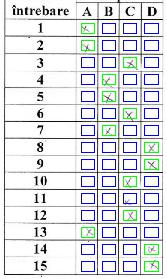

image_27 112


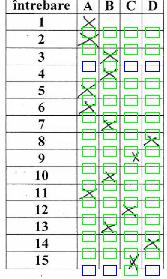

image_104 137
98.66666666666667 100.0 98.66666666666667


In [175]:
# Take the last lines as reference and draw the rest manually.

image_matching = np.empty((150,3))
image_matching[:] = np.NaN
for i in range(0,150):
    # read image and apply lines on each table
    image = read_image(i)
    
    image_name = images[i].split('/')[-1].split('.')[-2]
    ground_truth_content = np.loadtxt(os.path.join(base_folder, '%s.txt' % image_name), dtype=str)
#     print (image_name)
    # left table: ground truth, v and h lines
    image_left = split_first_table(image)
    image_lg = apply_filters(image_left)
    image_h = filter_horizontal(image_lg)
    image_v = filter_vertical(image_lg)
    h_lines_l = get_horizontal_lines(image_lg, image_h, 60)
    v_lines_l = get_vertical_lines(image_lg, image_v, 60)
    
    ground_truth_left = ground_truth_content[1:16]
    
    
    # right table: ground truth, v and h lines
    image_right = split_second_table(image)
    image_rg = apply_filters(image_right)
    image_h = filter_horizontal(image_rg)
    image_v = filter_vertical(image_rg)
    h_lines_r = get_horizontal_lines(image_rg, image_h, 60)
    v_lines_r = get_vertical_lines(image_rg, image_v, 60)
    
    ground_truth_right = ground_truth_content[16:-1]
    
    # get X-s, results and compare to ground truth
    results_left = find_x_from_img(image_lg, v_lines_l, h_lines_l, x_threshold)[0]
    results_right = find_x_from_img(image_rg, v_lines_r, h_lines_r, x_threshold)[0]
    image_matching[i][0] = verify_result(ground_truth_left, results_left)
    image_matching[i][1] = verify_result(ground_truth_right, results_right)
    image_matching[i][2] = (image_matching[i][0] + image_matching[i][1]) // 2
    if (image_matching[i][0] != 1):
        show_image(find_x_from_img(image_lg, v_lines_l, h_lines_l, x_threshold)[1])
        print (image_name, i)
    if (image_matching[i][1] != 1):
        show_image(find_x_from_img(image_rg, v_lines_r, h_lines_r, x_threshold)[1])
        print (image_name, i)
#     print (image_matching[i][0], image_matching[i][1], image_matching[i][2])
#     print (image_name, image_matching[i][0] == 1, image_matching[i][1] == 1, image_matching[i][2] == 1)

#     show_image(apply_lines(image_left))
#     show_image(apply_lines(image_right))
# print ("left:")
# print (image_matching)
total = np.sum(image_matching, axis=0)
print(total[0] * 100 / 150, total[1] * 100 / 150, total[2] * 100 / 150)